In [17]:
import rdkit
import deepchem as dc
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import time
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

# Optimizer
optimizer = tf.keras.optimizers.Adam(0.001)

#K-fold
k_fold = 4
k = k_fold
max_epoch = 100
# optimizer = tf.keras.optimizers.Adagrad(0.003)

In [2]:
rdkit.__version__

'2021.03.5'

In [3]:
dc.__version__

'2.5.0'

In [4]:
np.__version__

'1.19.5'

In [5]:
tf.__version__

'2.6.0'

In [6]:
# Loading molecular data
df = pd.read_csv('molecule_parameters.csv')
df.dropna(how='any', inplace=True)

In [7]:
# DDG Standard deviation
np.std(df.ddg)

2.697637870606162

In [8]:
# Normalizing entropy and add some noise
df['entropy'] = df['entropy'].astype(np.float) + np.random.normal(np.sqrt(df['entropy'].astype(np.float).mean()), 1, len(df))

# Reading PDB files

In [9]:
# start time
start = time.time()
# Dictionary with complex names as keys and molecule as values
PDBs = {}
from os import listdir
from os.path import isfile, join
# mypath = '../../../../../../Documents/GitHub/Binding-Free-Energy-Prediction-Host-Guest-System/pdbbind/raw-data/'
mypath = '../dataset/'
onlyfiles = [f for f in listdir(mypath) if f not in ('.DS_Store') and f in (df['complex-name'].tolist())]
for f in onlyfiles:
    print(f)
    PDBs.update({f: rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + f + '/com_new.pqr')})

for key, value in dict(PDBs).items():
    if value is None:
        del PDBs[key]
time.sleep(1)
# end time
end = time.time()
# total time taken
print(f"PDB file reading runtime is {(end - start)/60} minutes")

1bai
1bdq
1hn4
1bnv
1a1e
1bnq
1bn4
1bn3
1bhf
1c87
1c1r
1bgq
1jak
1c1u
1c86
1c88
1a4r
1bnw
1ai4
1b6l
1ajp
1b6k
1d3d
1hyo
1hvk
1bp0
1hvl
1b5j
1hsh
1ceb
1aid
1b3f
1gfy
1gi1
1b3h
1hvj
1hps
1ciz
1ajx
1ajq
1b6j
1ajv
1ai5
1hpo
1gi7
1iih
1gj6
1b0h
1b3g
1b52
1d3p
1b55
1add
1hwr
1amw
1b46
1b4z
1ghv
1gno
1j16
1ik4
1b4h
1ghw
1gnn
1adl
1b40
1d4l
1cbx
1d4k
1b8y
1ghy
1d7j
1hxw
1b7h
1d4p
1hxb
1bq4
1bwa
1d4y
1j17
1hos
1c5n
1bcd
1hi4
1gpk
1c5s
1a99
1c3x
1hi5
1a30
1c5o
1bjv
1i1e
1ax0
1hms
1hmt
1a4w
1bnu
1c84
1grp
1ctt
1c70
1c83
1atl
1a4k
1bnn
1bma
1dgm
1hk4


[18:59:54] Explicit valence for atom # 4629 O, 3, is greater than permitted
RDKit ERROR: [18:59:54] Explicit valence for atom # 4629 O, 3, is greater than permitted


1dhi
1c4u
1bn1
1ctu
1bm7
1bnt
1hmr
1bhx
1hsl
1b57
1d9i
1b3l
1hvs
1b32
1if7
1hpx
1b6h
1gjc
1ai7
1j36
1bzc
1cet
1iiq
1hpv
1d6v
1b5i
1hvh
1hvr
1b58
1afk
1d09
1bv7
1gi4
1afl
1bzy
1ajn
1alw
1bv9
1b51
1b05
1hvi
1aj7
1d6w
1b5h
1if8
1j01
1ii5
1b9j
1hp5
1ie9
1d2e
1b8n
1gaf
1aaq
1cnx
1igb
1cgl
1bxr
1b1h
1bty
1ikt
1br6
1b8o
1gar
1j14


[19:05:55] Explicit valence for atom # 940 O, 3, is greater than permitted
RDKit ERROR: [19:05:55] Explicit valence for atom # 940 O, 3, is greater than permitted


1bwb
1cnw
1gnm
1ado
1gai
1cny
1igj
1d7i
1j4r
1b2h
1ghz
1apv
1izi
1c5c
1bcu
1hii
1c5q
1df8
1ivp
1c5x
1cps
1gpn
1hlk
1izh
1i37
1bju
1a9m
1avn
1iy7
1det
1c5y
1a94
1a69
1c5p
1hih
PDB file reading runtime is 11.835844282309214 minutes


In [10]:
# Randomly shuffling the PDBs
import random
l = list(PDBs.items())
random.shuffle(l)
PDBs = dict(l)

# Models

<h3>PGNNS model </h3>

In [11]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
# batch_size = int(len(pdb_names_train)/4)
# batch_size
# batch_size=10

In [12]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers


class PGNNS(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
  def __init__(self, batch_size):
    super(PGNNS, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
    self.dense3 = layers.Dense(1, 
         kernel_initializer=initializers.Constant([0.5, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]),
         bias_initializer=initializers.Zeros())

  def call(self, inputs):
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    return self.dense3(binding_affinity)
# PGNNS = PGNNS(train_split_index)
# PGNNS.compile(loss='mse', optimizer='adam')

<h3> DDS</h3>

In [13]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers

# batch_size = int(len(df) / 2)

class DDS(tf.keras.Model):
   
    def modify_graphgather(self, batch_size):
        self.readout.batch_size = batch_size
        self.batch_size = batch_size

    def __init__(self, batch_size):
        super(DDS, self).__init__()
        self.input_shapes = None
        self.batch_size = batch_size
        self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm1 = layers.BatchNormalization()
        self.gp1 = GraphPool()

        self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm2 = layers.BatchNormalization()
        self.gp2 = GraphPool()

        self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
        self.batch_norm3 = layers.BatchNormalization()
        self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

        self.dense2 = layers.Dense(1)
    #     self.dense3 = layers.Dense(1, 
    #          kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
    #          bias_initializer=initializers.Zeros())

    def call(self, inputs):
        inputs = inputs[0]
        x = []
    #     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
    #                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
        for i in range(len(self.input_shapes)):
            x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
        for i in range(1, len(self.input_shapes)):
            x[i] = tf.cast(x[i], tf.int32)
        x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
        gc1_output = self.gc1(x)
        batch_norm1_output = self.batch_norm1(gc1_output)
        gp1_output = self.gp1([batch_norm1_output] + x[1:])

        gc2_output = self.gc2([gp1_output] + x[1:])
        batch_norm2_output = self.batch_norm1(gc2_output)
        gp2_output = self.gp2([batch_norm2_output] + x[1:])

        dense1_output = self.dense1(gp2_output)
        batch_norm3_output = self.batch_norm3(dense1_output)
        readout_output = self.readout([batch_norm3_output] + x[1:])

        model_var = self.dense2(readout_output)
    #     binding_affinity = tf.concat([model_var, x_add], axis=1)
        return model_var #self.dense3(binding_affinity)
# DDS_model = DDS(train_split_index)
# DDS_model.compile(loss='mse', optimizer="adam")

In [14]:
k

3

# K-fold

In [18]:
import warnings
warnings.filterwarnings('ignore')

TRAIN_SET_PERCENTAGE = 1-(1/k)
VAL_SET_PERCENTAGE = 1/k
PDBs.pop('',None)

# PGNNS model variables
PGNNS_train_losses = [[] for _ in range(k_fold)]
PGNNS_val_losses = [[] for _ in range(k_fold)]
PGNNS_rmse_train, PGNNS_rmse_test = [], []

# DDS model variables
DDS_train_losses = [[] for _ in range(k_fold)]
DDS_val_losses = [[] for _ in range(k_fold)]
DDS_rmse_train, DDS_rmse_test = [], []

# Defining Featurizer
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)

# start time
start = time.time()


# k-fold loop
for fold in range(k_fold):
    # fold=0 -> 0 * (0.25 * 72) = 0
    # fold=1 -> 1 * (0.25 * 72) = 18
    # fold=2 -> 2 * (0.25 * 72) = 36
    # fold=3 -> 3 * (0.25 *72) = 54
    X, X_ids, pdb_names_val, pdb_names_test = [], [], [], []
    pdb_names_train, X_val_featurized, X_test_featurized, X_train_featurized  = [], [], [], []
    

    # Featurize PDB's
    for i in PDBs.keys():
        X_ids.append(i)
        X.append(featurizer.featurize(PDBs[i]))

    pdb_names = [i.split('-')[0] for i in X_ids]  
    TEST_SIZE = int(len(X) * VAL_SET_PERCENTAGE)
    val_split_index_begin = int(fold * TEST_SIZE)
#     print(f"begin {val_split_index_begin}")
    val_split_index_end = int(val_split_index_begin) + int(TEST_SIZE)
#     print(f"end {val_split_index_end}")

    # validation
    pdb_names_val = pdb_names[val_split_index_begin:val_split_index_end]

    # Test set
    pdb_names_test = pdb_names[val_split_index_begin:val_split_index_end]
    
    # Train set
    pdb_names_train = [pdb_names[i] for i in range(len(pdb_names)) if i not in range(val_split_index_begin,val_split_index_end)]


    X = [x[0] for x in X]
    
    X_val_featurized = X[val_split_index_begin : val_split_index_end]
    X_test_featurized = X[val_split_index_begin : val_split_index_end]
    X_train_featurized = [X[i] for i in range(len(X)) if i not in range(val_split_index_begin, val_split_index_end)]
    
    ### Step
    
    x_add_train, x_add_val, x_add_test, y_train, y_val, y_test = [], [], [], [], [], []
    # Train
    for i in range(len(pdb_names_train)):
        new_df = df[(df['complex-name'] == pdb_names_train[i])]
        y_train.append(new_df['ddg'].to_numpy()[0])
        x_add_train.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_train = np.array(y_train)
    # Val
    for i in range(len(pdb_names_val)):
        new_df = df[(df['complex-name'] == pdb_names_val[i])]
        y_val.append(new_df['ddg'].to_numpy()[0])
        x_add_val.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_val = np.array(y_val)

    # Test
    for i in range(len(pdb_names_test)):
        new_df = df[(df['complex-name'] == pdb_names_test[i])]
        y_test.append(new_df['ddg'].to_numpy()[0])
        x_add_test.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_test = np.array(y_test)
    
    x_preprocessed_train, x_preprocessed_val, x_preprocessed_test = [], [], []
    
    ## Step
    
    # X train
    multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
    x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_train.append(np.array(x_add_train))

    ## X val
    multiConvMol = ConvMol.agglomerate_mols(X_val_featurized)
    x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_val.append(np.array(x_add_val))


    ## X test
    multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
    x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_test.append(np.array(x_add_test))
    
    ### Step
    
    # Train
    x_train = np.full([15, np.max([v.shape[0] for v in x_preprocessed_train]),
                      np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_train):
        if len(j.shape) > 1:
            x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_train = x_train.reshape([1] + list(x_train.shape))

    # Validation
    x_val = np.full([15, np.max([v.shape[0] for v in x_preprocessed_val]),
                      np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_val):
        if len(j.shape) > 1:
            x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_val = x_val.reshape([1] + list(x_val.shape))

    # Test
    x_test = np.full([15, np.max([v.shape[0] for v in x_preprocessed_test]),
                      np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_test):
        if len(j.shape) > 1:
            x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_test = x_test.reshape([1] + list(x_test.shape))
    
    # Variable initializations for models
    
    val_size = len(y_val)
    train_size = len(y_train)
    
    # PGNNS Model
    batch_size = len(pdb_names_train)
    PGNNS_model = PGNNS(len(y_train))
    PGNNS_model.compile(loss='mse', optimizer=optimizer)
    print(f'PGNNS Model Fold # {fold}')
    for epoch in range(max_epoch):
        PGNNS_model.modify_graphgather(train_size)
        PGNNS_model.input_shapes = [i.shape for i in x_preprocessed_train]
        PGNNloss = PGNNS_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
        PGNNS_train_losses[fold].append(PGNNloss.history['loss'][0])
        PGNNS_model.input_shapes = [i.shape for i in x_preprocessed_val]
        PGNNS_model.modify_graphgather(val_size)
        PGNNS_val_losses[fold].append(PGNNS_model.evaluate(x_val, y_val.reshape([1, -1])))
        
    PGNNS_model.input_shapes = [i.shape for i in x_preprocessed_test]
    PGNNS_model.modify_graphgather(len(y_test))
    evalu = PGNNS_model.evaluate(x_test, y_test.reshape([1, -1]))
    # PGNNS Testing RMSE calculation
    PGNNS_rmse_test.append(np.sqrt(evalu))
    print(PGNNS_rmse_test)
    # PGNNS Training RMSE calculation
    PGNNS_train_loss = PGNNS_train_losses[fold][-1]
    PGNNS_rmse_train.append(math.sqrt(PGNNS_train_loss))
    
    # Data Driven model
    DDS_model = DDS(len(y_train))
    DDS_model.compile(loss='mse', optimizer=optimizer)
    print(f'DDS Model Fold # {fold}')
    for epoch in range(max_epoch):
        DDS_model.modify_graphgather(train_size)
        DDS_model.input_shapes = [i.shape for i in x_preprocessed_train]
        DDSloss = DDS_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
        DDS_train_losses[fold].append(DDSloss.history['loss'][0])
        DDS_model.input_shapes = [i.shape for i in x_preprocessed_val]
        DDS_model.modify_graphgather(val_size)
        DDS_val_losses[fold].append(DDS_model.evaluate(x_val, y_val.reshape([1, -1])))
    
    DDS_model.input_shapes = [i.shape for i in x_preprocessed_test]
    DDS_model.modify_graphgather(len(y_test))
    DDS_evaluate = DDS_model.evaluate(x_test, y_test.reshape([1, -1]))
    # DDS Testing RMSE calculation
    DDS_rmse_test.append(np.sqrt(DDS_evaluate))
    print(DDS_rmse_test)
    # DDS training RMSE calculation
    DDS_train_loss = DDS_train_losses[fold][-1]
    DDS_rmse_train.append(math.sqrt(DDS_train_loss))
    
time.sleep(1)
# end time
end = time.time()
# total time taken
print(f"Model training and testing runtime is {(end - start)/60} minutes")

PGNNS Model Fold # 0
1/1 [==============================] - 2s 2s/step - loss: 15.5437
[3.9425560112592573]
DDS Model Fold # 0
1/1 [==============================] - 1s 1s/step - loss: 76.0845


1/1 [==============================] - 2s 2s/step - loss: 46.2102
[6.797808002145486]
PGNNS Model Fold # 1
1/1 [==============================] - 21s 21s/step - loss: 23.7918


1/1 [==============================] - 1s 1s/step - loss: 29.0567
[3.9425560112592573, 5.390423137921082]
DDS Model Fold # 1
1/1 [==============================] - 8s 8s/step - loss: 7.9991


1/1 [==============================] - 1s 1s/step - loss: 59.6595
[6.797808002145486, 7.723958223582546]
PGNNS Model Fold # 2
1/1 [==============================] - 17s 17s/step - loss: 20.3306


1/1 [==============================] - 3s 3s/step - loss: 16.0551
[3.9425560112592573, 5.390423137921082, 4.006885324648413]
DDS Model Fold # 2
1/1 [==============================] - 2s 2s/step - loss: 32.0484
[6.797808002145486, 7.723958223582546, 5.661129022149197]
PGNNS Model Fold # 3
1/1 [==============================] - 1s 1s/step - loss: 47284.9844


1/1 [==============================] - 2s 2s/step - loss: 26.5483
[3.9425560112592573, 5.390423137921082, 4.006885324648413, 5.152500523285374]
DDS Model Fold # 3
1/1 [==============================] - 1s 857ms/step - loss: 52.5955


1/1 [==============================] - 1s 761ms/step - loss: 27.8998
[6.797808002145486, 7.723958223582546, 5.661129022149197, 5.282026606234554]
Model training and testing runtime is 302.6788311362267 minutes


In [ ]:
PDBs

In [19]:
# chekcing the wights after training PGNNS MODEL
PGNNS_model.layers[-1].get_weights()

[array([[ 0.45660985],
        [ 1.0000306 ],
        [ 1.0000203 ],
        [ 1.000022  ],
        [ 1.0004455 ],
        [-0.99995726],
        [-0.99997145],
        [-1.0000222 ],
        [-0.9995073 ],
        [-1.0033538 ],
        [-1.0107503 ],
        [-1.0006651 ],
        [-0.99364555],
        [ 1.0000036 ],
        [-0.9999289 ],
        [-1.011449  ],
        [-0.99902534]], dtype=float32),
 array([0.00388045], dtype=float32)]

In [20]:
# calculating the average RMSE on Training set
average_DDS_rmse_train = sum(DDS_rmse_train) / len(DDS_rmse_train)
average_PGNNS_rmse_train = sum(PGNNS_rmse_train) / len(PGNNS_rmse_train)
# calculating the average RMSE on Testing set
average_DDS_rmse_test = sum(DDS_rmse_test) / len(DDS_rmse_test)
average_PGNNS_rmse_test = sum(PGNNS_rmse_test) / len(PGNNS_rmse_test)

# Model Performance Graphs

<h3>PGNNS Model </h3>

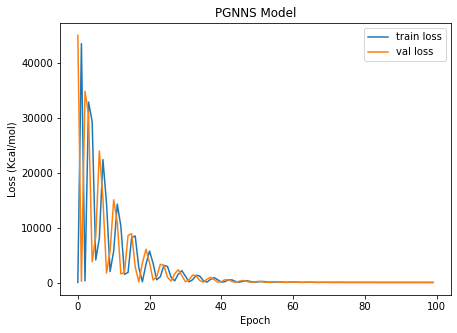

In [21]:
import matplotlib.pyplot as plt
# Calculating the average of k-fold losses
average_PGNNS_train_losses = [sum(x)/len(x) for x in zip(*PGNNS_train_losses)]
average_PGNNS_val_losses = [sum(x)/len(x) for x in zip(*PGNNS_val_losses)]
plt.figure(figsize=(7,5))
plt.plot(range(len(average_PGNNS_train_losses)), average_PGNNS_train_losses, label='train loss')
plt.plot(range(len(average_PGNNS_val_losses)), average_PGNNS_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.title("PGNNS Model")
# Time stamp with date and time
time.strftime("%Y-%m-%d %H%M%S")

# save plot
plt.savefig("PGNNS_loss" + time.strftime("%Y-%m-%d %H%M%S") + ".png")

<h3>DDS Model </h3>

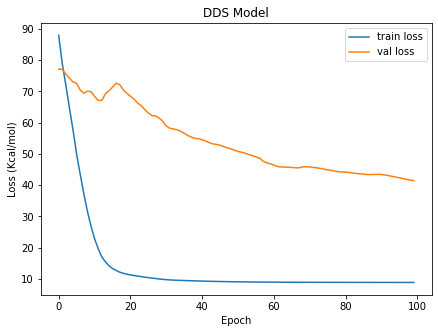

In [22]:
import matplotlib.pyplot as plt
# Calculating the average of k-fold losses
average_DDS_train_losses = [sum(x)/len(x) for x in zip(*DDS_train_losses)]
average_DDS_val_losses = [sum(x)/len(x) for x in zip(*DDS_val_losses)]
plt.figure(figsize=(7,5))
plt.plot(range(len(average_DDS_train_losses)), average_DDS_train_losses, label='train loss')
plt.plot(range(len(average_DDS_val_losses)), average_DDS_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.title('DDS Model')
# Time stamp with date and time
time.strftime("%Y-%m-%d %H%M%S")

# save plot
plt.savefig("DDS_loss" + time.strftime("%Y-%m-%d %H%M%S") + ".png")

# Comparison

In [25]:
from prettytable import PrettyTable
# Train
rmse_table = PrettyTable()
rmse_table.title="Models Comparison"
rmse_table.field_names = ["DDS (TRAIN)", "PGNNS (TRAIN)", "DDS (TEST)", "PGNNS (TEST)"]
rmse_table.add_row([ "{:.2f}".format(average_DDS_rmse_train),"{:.2f}".format(average_PGNNS_rmse_train),
                   "{:.2f}".format(average_DDS_rmse_test),"{:.2f}".format(average_PGNNS_rmse_test)])
print(rmse_table) 



+---------------------------------------------------------+
|                    Models Comparison                    |
+-------------+---------------+------------+--------------+
| DDS (TRAIN) | PGNNS (TRAIN) | DDS (TEST) | PGNNS (TEST) |
+-------------+---------------+------------+--------------+
|     2.97    |      4.07     |    6.37    |     4.62     |
+-------------+---------------+------------+--------------+
